# DNN for learning Coulomb Blockade
A simple DNN will be used to learn to *integrate* the current characteristics to find the charge on the device.

In [1]:
import numpy as np
import os
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import time

In [3]:
file_list = glob.glob("/Users/sandesh/data_for_paper/single_dot/*.npy")
print("Number of files",len(file_list))
data_list = [np.load(f).item() for f in file_list]
print("Data keys",data_list[0].keys())

Number of files 699
Data keys dict_keys(['V_P_vec', 'type', 'physics', 'output'])


## Sample Current and Charge Traces from the data

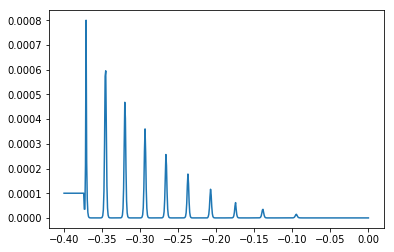

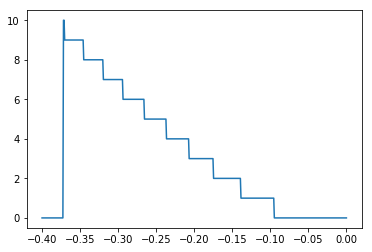

In [9]:
# sample data plots
file_index = np.random.randint(len(file_list))
V_P_vec = data_list[file_index]['V_P_vec']
current_vec = [x['current'] for x in data_list[file_index]['output']]
charge_vec = [np.sum(x['charge']) for x in data_list[file_index]['output']]

plt.figure(1)
plt.plot(V_P_vec,current_vec)

plt.figure(2)
plt.plot(V_P_vec,charge_vec)

## Loading of the data
The data is put into separate input and output lists so that it works with the code of the DNN from tensorflow.

In [17]:
inp_array = []
out_array = []
for dat in data_list:
    inp_array.append(np.array([x['current'] for x in dat['output']]))
    out_array.append(np.array([np.sum(x['charge']) for x in dat['output']]))
inp_array = np.array(inp_array)
out_array = np.array(out_array)

## Constructing the DNN Regressor
A packaged DNN is used from the tensorflow.contrib.learn.DNNRegressor API.

In [31]:
model_dir_path = "/Users/sandesh/trained_networks/single_dot/"
# determines the number of inputs used as the training set
# the rest are treated as a test set
train_factor = 0.9

n_tot = inp_array.shape[0]
n_train = int(train_factor*n_tot)
n_test = n_tot - n_train

# input parameters
n_inp = inp_array[0].shape[0] 
n_out = out_array[0].shape[0] 
print("Number of inputs:", n_inp)
print("Number of outputs:", n_out)

x_test_data = inp_array[n_train:]
y_test_data = out_array[n_train:].astype(int)

print("Total, Training, Test")
print(n_tot, n_train, n_test)

def get_train_inputs():
    # load a random batch of batch_size to perform the training
    batch_size = 25
    idx = np.random.randint(n_train,size=batch_size)
    
    x_train_data = inp_array[idx,:]
    y_train_data = out_array[idx,:].astype(int)
    x = tf.constant(x_train_data)
    y = tf.constant(y_train_data)
    return x,y

def get_test_inputs():
    x = tf.constant(x_test_data)
    y = tf.constant(y_test_data)
    return x,y

# load datasets
features = [tf.contrib.layers.real_valued_column("",dimension=n_inp)]
regressor = tf.contrib.learn.DNNRegressor(feature_columns=features,
                                          label_dimension=n_out,
                                          hidden_units=[512,256,128],
                                          optimizer=tf.train.AdamOptimizer(learning_rate=0.1),
                                          model_dir = model_dir_path,
                                         )
st = time.time()
regressor.fit(input_fn=get_train_inputs, steps=10000)

print("Completed in",time.time()-st, "seconds.")

predictions = list(regressor.predict(input_fn=get_test_inputs))
def eval_accur(y1,y2):
    diff = np.abs(y1-y2)
    return len(np.where(diff == 0)[0])*1.0/len(diff)
accur = [eval_accur(x,y) for (x,y) in zip(y_test_data[:],np.rint(predictions))]
print("Accuracy : ",np.mean(accur))

Number of inputs: 512
Number of outputs: 512
Total, Training, Test
699 629 70
Completed in 80.95176887512207 seconds.
Accuracy :  0.499581473214


## Predict using the trained DNN
The accuracy for each sample is calculated as the number of points in the voltage space where it correctly predicts the charges. The total accuracy is defined as the mean over all the samples in the test set.

In [32]:
predictions = list(regressor.predict(input_fn=get_test_inputs))
def eval_accur(y1,y2):
    diff = np.abs(y1-y2)
    return len(np.where(diff == 0)[0])*1.0/len(diff)
accur = [eval_accur(x,y) for (x,y) in zip(y_test_data[:],np.rint(predictions))]
print("Accuracy : ",np.mean(accur))

Accuracy :  0.499581473214


## Sample Predictions
A random sample from the test set is picked and the output from the DNN is compared with the actual expected output as a visualisation.

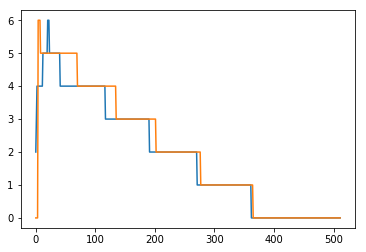

In [49]:
index = np.random.randint(n_test)
plt.plot(np.rint(predictions[index]))
plt.plot(y_test_data[index])